# Finetuning with Trainer and text-classification model validation

In [1]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
   colab = True
else:
   colab = False

if colab:
    !pip install transformers[torch]
    !pip install accelerate -U
    !pip install datasets
    !pip install torchinfo
    #ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.20.1`: Please run `pip install transformers[torch]` or `pip install accelerate -U

In [2]:
from sklearn.model_selection import train_test_split
import datetime
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import seaborn as sn
import torch

from datasets import load_dataset, Dataset, DatasetDict
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from torchinfo import summary
from transformers import AutoModelForSequenceClassification, AutoConfig, Trainer, TrainingArguments, DataCollatorWithPadding, AutoTokenizer, pipeline
from transformers.modelcard import parse_log_history

# Prepare parameters for each run of finetnuning

In [3]:
# from huggingface_hub import notebook_login
# notebook_login()

In [4]:
# models = ['albert', 'bart', 'bert', 'big_bird', 'bigbird_pegasus', 'biogpt', 'bloom', 'camembert', 'canine', 'code_llama', 'convbert', 'ctrl', 'data2vec-text', 'deberta', 'deberta-v2', 'distilbert', 'electra', 'ernie', 'ernie_m', 'esm', 'falcon', 'flaubert', 'fnet', 'funnel', 'gemma', 'gpt-sw3', 'gpt2', 'gpt_bigcode', 'gpt_neo', 'gpt_neox', 'gptj', 'ibert', 'layoutlm', 'layoutlmv2', 'layoutlmv3', 'led', 'lilt', 'llama', 'longformer', 'luke', 'markuplm', 'mbart', 'mega', 'megatron-bert', 'mistral', 'mixtral', 'mobilebert', 'mpnet', 'mpt', 'mra', 'mt5', 'mvp', 'nezha', 'nystromformer', 'open-llama', 'openai-gpt', 'opt', 'perceiver', 'persimmon', 'phi', 'plbart', 'qdqbert', 'qwen2', 'reformer', 'rembert', 'roberta', 'roberta-prelayernorm', 'roc_bert', 'roformer', 'squeezebert', 'stablelm', 'starcoder2', 't5', 'tapas', 'transfo-xl', 'umt5', 'xlm', 'xlm-roberta', 'xlm-roberta-xl', 'xlnet', 'xmod', 'yoso',]
# =============================================
# tested = 'distilbert-base-cased', 'camembert-base', 'ctrl', 'transfo-xl-wt103', 'xlnet-base-cased', 'roberta-base', 'distilroberta-base', 'flaubert/flaubert_base_cased'
# ----------
#too weak pc (cannot be loaded or runs at speeds <1 it/s) = 'albert-xlarge-v1', 't5-11B', 'LongformerForSequenceClassification', 'xlm-roberta-base', 'allenai/longformer-base-4096', 'facebook/bart-large',  flaubert/flaubert_large_cased (stopped at 0.5 epoch), 'HuggingFaceH4/tiny-random-LlamaForSequenceClassification'
# ----------
#need changes to run (check error logs) =  ProsusAI/finbert (despite adding padding proposed in error)
# =============================================
# model_path = 'SamLowe/roberta-base-go_emotions'
# model_path = 'distilbert-base-uncased'
# model_path = 'xlmoberta'

# , 'camembert-base', 'ctrl', 'transfo-xl-wt103', 'xlnet-base-cased', 'roberta-base', 'distilroberta-base', 'flaubert/flaubert_base_cased'

#if list of objects is provided list of all combinations of parameters will be created for running
params_tested = {'model': ['distilbert-base-cased'],
                 'num_train_epochs': 10,
                 'save_strategy': 'no',
                 'per_device_train_batch_size': 8,
                 'per_device_eval_batch_size': 64,
                 'split': (80, 20) #may be tuple of len 2/3, dividing respectively into 2:{train, test} and 3:{train, test, validate}. By default labels are stratified. You may pass "balanced" instead of the last element, number of labels for each class will be     
                 }
import numbers
split_s = sum([i for i in params_tested['split'] if isinstance(i, numbers.Integral)])
params_tested['split'] = tuple([i/split_s if isinstance(i, numbers.Integral) else i for i in params_tested['split']])
     


params_tested={i:[q] if type(q) is not list else q for (i,q) in params_tested.items()}
keys = list(params_tested.keys())
combinations = list(itertools.product(*params_tested.values()))
result = [{keys[i]: combination[i] for i in range(len(keys))} for combination in combinations]
print(*result, sep='\n')

train_params_looped = result

{'model': 'distilbert-base-cased', 'num_train_epochs': 10, 'save_strategy': 'no', 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 64, 'split': (0.9, 0.1, 'balanced')}


## Functions

In [12]:
def df_to_ds(df, train_params_instance):
    temp_split = train_params_instance['split']
    
    target_map = {k:i for i,k in enumerate(df['label'].unique())}
    reversed_target_map = {v:k for k, v in target_map.items()}
    
    df['label'] = df['label'].map(target_map)
    
    if temp_split[-1]=='balanced' or len(temp_split)==2:
        if temp_split[-1]=='balanced':
            split = [pd.Series(name='sentence'), pd.Series(name='sentence'), pd.Series(name='label'), pd.Series(name='label')]
            n_for_training = df.groupby('label').count()['Source'].min()
            train_percentage = df.groupby('label').count()['Source'].apply(lambda x: (temp_split[0]*n_for_training)/x).to_dict()
            
            for label_name, group in df.groupby('label'):
                split_t = train_test_split(group['sentence'], group['label'], test_size=1-train_percentage[label_name], random_state=42, shuffle=True)
                split = [pd.concat([i[0],i[1]], axis=0) for i in zip(split, split_t)]
        else:
            split = train_test_split(df['sentence'], df['label'], stratify=df['label'], test_size=temp_split[1], random_state=42, shuffle=True)
        ds = DatasetDict()
        ds['train'] = Dataset.from_pandas(pd.concat([split[0], split[2]], axis=1))
        ds['test'] = Dataset.from_pandas(pd.concat([split[1], split[3]], axis=1))
    elif len(temp_split)==3:
        non_train_size = 1-temp_split[0]
        split = train_test_split(df['sentence'], df['label'], stratify=df['label'], test_size=non_train_size, random_state=42, shuffle=True)
        split2 = train_test_split(df['sentence'], df['label'], stratify=df['label'], test_size=temp_split[2]/non_train_size, random_state=42, shuffle=True)
        ds = DatasetDict()
        ds['train'] = Dataset.from_pandas(pd.concat([split[0], split[2]], axis=1))
        ds['test'] = Dataset.from_pandas(pd.concat([split2[0], split2[2]], axis=1))
        ds['validate'] = Dataset.from_pandas(pd.concat([split2[1], split2[3]], axis=1))
    return ds, target_map, reversed_target_map

def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy': acc, 'f1': f1}

def save_logs_from_training_run(trainer, train_params, timestamp, trained_model_path, colab):
    log_history = parse_log_history(trainer.state.log_history)
    log_df = pd.DataFrame(log_history[1])
    log_df.insert(0, 'model', train_params['model'])
    log_df.insert(0, 'timestamp', timestamp)
    log_df['model_path'] = trained_model_path
    log_df['samples_per_s'] = log_history[0]['train_samples_per_second']
    log_df['steps_per_s'] = log_history[0]['train_steps_per_second']
    log_df['colab'] = colab
    log_df['per_device_train_batch_size'] = train_params['per_device_train_batch_size']
    log_df['per_device_eval_batch_size'] = train_params['per_device_eval_batch_size']
    log_df['split'] = str(train_params['split'])

    float_cols = log_df.select_dtypes(include='float64')
    log_df[float_cols.columns] = float_cols.apply(lambda x: round(x, 3))
    log_df.to_csv('output/training_logs.csv', mode='a', header= not os.path.isfile('output/training_logs.csv'), index=False)
    
def finetune(train_params, ds):
    params_passed = {k: train_params[k] for k in train_params if k not in ['model', 'split']}
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
    trained_model_path = f'output/models/{train_params['model']}_{timestamp}'

    try:
        def tokenize_fn(batch):
            return tokenizer(batch['sentence'], truncation=True)
    
        #Tokenize dataset
        tokenizer = AutoTokenizer.from_pretrained(train_params['model'], trust_remote_code=True)
        tokenizer.pad_token = tokenizer.eos_token
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        tokenized_datasets = ds.map(tokenize_fn, batched=True)
    
        #Change labels
        config = AutoConfig.from_pretrained(train_params['model'], trust_remote_code=True)
        config.id2label = reversed_target_map
        config.label2id = target_map
    
        #Load model
        model = AutoModelForSequenceClassification.from_pretrained(
            train_params['model'], config=config, ignore_mismatched_sizes=True, trust_remote_code=True)
    
        if torch.cuda.is_available():
            model = model.cuda()
            device = 'gpu'
        else:
            device = 'cpu'
    
        training_args = TrainingArguments(
          output_dir=f'{trained_model_path}/checkpoints',
          evaluation_strategy='epoch',
          logging_strategy='epoch',
          **params_passed
        )
    
        trainer = Trainer(
            model,
            training_args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["test"],
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
        )
    
        trainer.train()
        save_logs_from_training_run(trainer, train_params, timestamp, trained_model_path, colab)

    except Exception as e:
        print(f'Error: {e}')
        err_df = pd.DataFrame([[trained_model_path, str(e)]])
        err_df.to_csv('output/error_logs.csv', mode='a', index=False)
        
        
def to_binary_classification(x):
    if x in ['Positive', 'Negative']:
        return 'Pathos'
    else:
        return x

## Run

In [14]:
# Load PolarIs-Pathos to df
if colab:
  from google.colab import drive
  drive.mount('/content/drive')
  data_path = 'drive/MyDrive/master_lm/PolarIs-Pathos.xlsx'
else:
  data_path = 'data/PolarIs-Pathos.xlsx'

df = pd.read_excel(data_path)
df['label'] = df[['No_pathos', 'Positive', 'Negative']].idxmax(axis=1)
df['label'] = df['label'].apply(lambda x: to_binary_classification(x))
df = df.rename(columns={'Sentence':'sentence'})

In [15]:
#run looped 
for train_params in train_params_looped[:1]:
    ds, target_map, reversed_target_map, = df_to_ds(df, train_params)    
    finetune(train_params, ds)

C:\Users\Jakub\AppData\Local\Temp\ipykernel_23116\2206075159.py:17: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  split = [pd.concat([i[0],i[1]], axis=0) for i in zip(split, split_t)]


Map:   0%|          | 0/8910 [00:00<?, ? examples/s]

Map:   0%|          | 0/6678 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Jakub\DataspellProjects\EQILLM\venv\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.641200,0.719564,0.619946,0.485257
2,0.501400,0.905843,0.513926,0.424212
3,0.334600,0.852170,0.744684,0.547392
4,0.214400,1.210742,0.721623,0.531668
5,0.122600,1.730574,0.700958,0.524100
6,0.064900,2.017568,0.690925,0.521196
7,0.039400,2.358633,0.662773,0.505020
8,0.031700,2.143698,0.703205,0.523647
9,0.016000,2.632761,0.673405,0.508132
10,0.015100,2.712164,0.671009,0.506584


In [16]:
ds

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', '__index_level_0__'],
        num_rows: 8910
    })
    test: Dataset({
        features: ['sentence', 'label', '__index_level_0__'],
        num_rows: 6678
    })
})

### Classification

In [154]:
# Get last epoch number
checkpoint_no = [int(i.rsplit('-')[-1]) for i in os.listdir(f'{trained_model_path}/checkpoints/') if i.startswith('checkpoint')]
checkpoint_no.sort(reverse=True)
print(checkpoint_no)
chosen_checkpoint = checkpoint_no[0]
checkpoint_path = f'{trained_model_path}/checkpoints/checkpoint-{chosen_checkpoint}'

NameError: name 'trained_model_path' is not defined

In [ ]:
def validate(checkpoint_path, validation_ds, reversed_target_map, save=True):
    task = 'text-classification'
    classif_out_path = checkpoint_path.rsplit('/', 1)[0]
    classifier = pipeline(task, model=checkpoint_path, device=0)
    predicted = classifier(validation_ds['sentence'])
    out_df = pd.DataFrame(ds['sentence', 'label'], columns=['sentence', 'label'])
    out_df['predicted'] = [i['label'] for i in predicted]
    return predicted

In [ ]:
validated_df = pd.concat([X_val, y_val], axis=1).copy(deep=True)
# validated_df = ds_dict['validate'].copy(deep=True)
validated_df['predicted'] = [i['label'] for i in pred_val]
validated_df['label'] = validated_df['label'].map(reversed_target_map)
validated_df.to_csv(f'{trained_model_path}/validated.csv', index=False)

acc: 0.742142398973701
f1: 0.5915645247082992


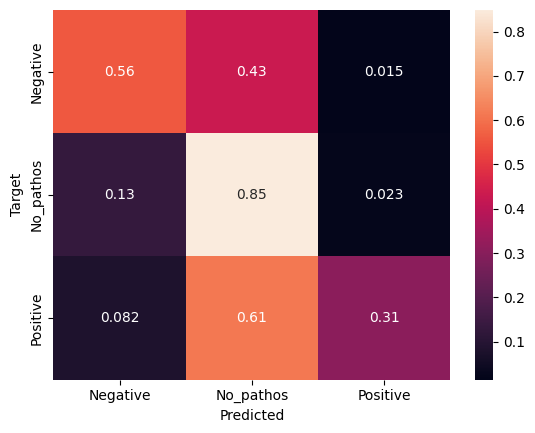

In [ ]:
print("acc:", accuracy_score(validated_df['label'], validated_df['predicted']))
print("f1:", f1_score(validated_df['label'], validated_df['predicted'], average='macro'))

def plot_cm(cm):
    classes = list(target_map.keys())
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='.2g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

cm = confusion_matrix(validated_df['label'], validated_df['predicted'], normalize='true')
plot_cm(cm)

In [ ]:
validated_df.groupby('label').count()

,sentence,predicted
label,,
Negative,410,410
No_pathos,1064,1064
Positive,85,85


In [ ]:
# def softmax(x):
#     """Compute softmax values for each sets of scores in x."""
#     e_x = np.exp(x - np.max(x))
#     return e_x / e_x.sum(axis=0) # only difference
# 
# 
# softmax([0.2, 0.3, 0.9])